#### This notebook shows how to read the CMRxRecon2025 dataset and apply some simple transformations to the data.
#### We utilized some useful codes from fastMRI repo.

In [1]:
%matplotlib inline

import h5py
import numpy as np
from matplotlib import pyplot as plt
import hdf5storage
import os


The CMRxRecon dataset is distributed as a set of HDF5 files and can be read with the h5py package. Here, we first show how to open a file from the multi-coil dataset. Each file corresponds to ntime * nslice of MRI scan and contains the k-space data.

In [2]:
rootdir = "F:/CMRxRecon2025/ChallengeData/MultiCoil/Cine/TrainingSet/"
file_name = os.path.join(rootdir,"FullSample", "Center005","Siemens_30T_Vida","P003","cine_sax.mat")
hf_m = h5py.File(file_name)

In [3]:
print('Keys:', list(hf_m.keys()))

Keys: ['kspace']


In [4]:
# here to load the kspace data
newvalue = hf_m['kspace']
fullmulti = newvalue["real"] + 1j*newvalue["imag"]

In [5]:
[nframe, nslice, ncoil, ny, nx] = fullmulti.shape
print(nframe, nslice, ncoil, ny, nx)

12 14 10 162 448


In multi-coil MRIs, k-space has the following shape: 

#number of frame, number of slices, number of coils, ny, nx (ny is the phase encoding direction for undersampling)

For single-coil MRIs, k-space has the following shape: #number of frame, number of slices, ny, nx


In [6]:
# choose the first frame and the middle slice
slice_kspace = fullmulti[0,5] 

Let's see what the absolute value of k-space looks like:

In [7]:
def show_coils(data, slice_nums, cmap=None, vmax = 0.0005):
    fig = plt.figure()
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap,vmax=vmax)

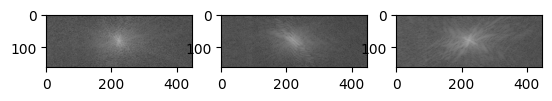

In [9]:
show_coils(np.log(np.abs(slice_kspace) + 1e-9), [0, 4, 9], cmap='gray', vmax = 0.0001)  # This shows coils 0, 4 and 9

We acknowledged fastMRI repo for their utlity functions to convert k-space into image space. These functions work on PyTorch Tensors. The to_tensor function can convert Numpy arrays to PyTorch Tensors.

In [11]:
import fastmri
from fastmri.data import transforms as T

In [12]:
slice_kspace2 = T.to_tensor(slice_kspace)              # Convert from numpy array to pytorch tensor
slice_image = fastmri.ifft2c(slice_kspace2)           # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = fastmri.complex_abs(slice_image)   # Compute absolute value to get a real image

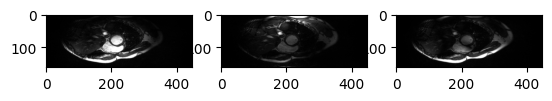

In [13]:
show_coils(slice_image_abs, [0, 1, 2], cmap='gray', vmax = 0.0005)

As we can see, each coil in a multi-coil MRI scan focusses on a different region of the image. These coils can be combined into the full image using the Root-Sum-of-Squares (RSS) transform.

In [14]:
slice_image_rss = fastmri.rss(slice_image_abs, dim=0)

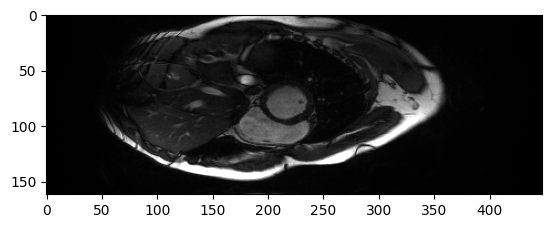

In [56]:
plt.imshow(np.abs(slice_image_rss.numpy()), cmap='gray', vmax = 0.0015)

So far, we have been looking at fully-sampled multi-coil data. We can apply the mask to the kspace and get the undersampled images. 

In [15]:
mask_name = os.path.join(rootdir, "Mask_TaskAll", "Center005","Siemens_30T_Vida","P003","cine_sax_mask_ktGaussian8.mat")
mask_s = h5py.File(mask_name)

In [16]:
print('Keys:', list(mask_s.keys()))

Keys: ['mask']


In [17]:
# here to load the kspace data, the keys are differnt for different acceleration factors
mask = mask_s['mask']
print(mask.shape)

(12, 162, 448)


In [18]:
# apply the mask to the kspace to undersample
underslice = slice_kspace * mask[0,:,:]

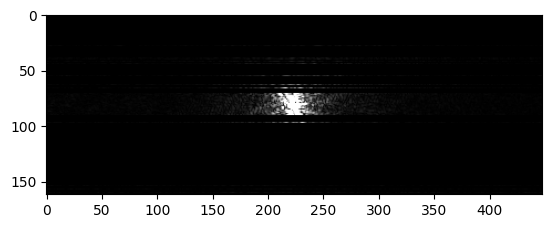

In [19]:
plt.imshow(np.abs(underslice[0]), cmap='gray', vmax = 0.001)

Let's see what the subsampled image looks like:

In [20]:
underslice2 = T.to_tensor(underslice)              # Convert from numpy array to pytorch tensor
sampled_image = fastmri.ifft2c(underslice2)           # Apply Inverse Fourier Transform to get the complex image
sampled_image_abs = fastmri.complex_abs(sampled_image)   # Compute absolute value to get a real image
sampled_image_rss = fastmri.rss(sampled_image_abs, dim=0)

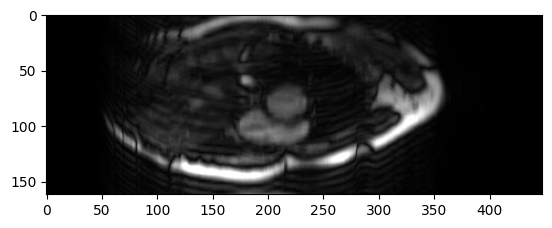

In [21]:
plt.imshow(np.abs(sampled_image_rss.numpy()), cmap='gray',vmax = 0.0015)

Here we try to save the numpy to mat73 file, please use hdf5storage function. 
For a large numpy array, it may take a longer time (e.g. up to two minutes for a multi-coil file). 

In [22]:
def savenumpy2mat(data, np_var, filepath):
    ''' 
    np_var: str, the name of the variable in the mat file.
    data: numpy, array to save.
    filepath: str, the path to save the mat file.
    '''
    savedict= {}
    savedict[np_var] = data
    hdf5storage.savemat(filepath, savedict)


In [23]:
savenumpy2mat(underslice, 'underkspace', 'underkslice.mat')